In [1]:
from __future__ import division
import imp
import uproot
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
helper = imp.load_source('helpfunction','/home/tmettler/Desktop/uBoone/do_plots/helpfunction.py')
globale = imp.load_source('globale','/home/tmettler/Desktop/uBoone/do_plots/globale.py')

#import /home/tmettler/Desktop/uBoone/do_plots/helpfunction as helper
import collections
NuCC = imp.load_source('NuCC_function','/home/tmettler/Desktop/uBoone/do_plots/NuCC_function.py')

Welcome to JupyROOT 6.10/08


In [2]:
#!jupyter nbconvert --to script numuCCana_muon_cut_V33.ipynb

In [3]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


# CRTinBNB tagger, Overlay or MC

In [4]:
# Load input files
#inputdir = '/home/thomasm/numuCC/V33/10kevents/'
inputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
outputdir = inputdir+'muon_cut/' 
outputdir_png, outputdir_root = NuCC.prepareOutput(outputdir)

#filename_overlay = 'NuCCana_Overlay_V18_V4.root'
filename_overlay = 'NuCCana_overlay_V26_weight.root'
filename_data = 'NuCCana_data_V22.root'
filename_ext = 'NuCCana_ext_V25.root'
filename_dirt = 'NuCCana_dirt_V26_weight.root'
    
tree_name = 'numuCCAna'

In [5]:
#Open all the trees of the four files (data, ext, dirt, overlay)

data, ext, dirt, overlay = NuCC.openTrees(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
NuCC.printNumberOfEntries(data,ext,dirt,overlay)

pot_overlay = NuCC.getPOT(inputdir,filename_overlay,tree_name)
pot_dirt =  NuCC.getPOT(inputdir,filename_dirt,tree_name)

#V25 files
pot_data =      8.649e+18 # tor860_wcut
data_trigger = 1854495.0 #4743794 # 1987072.0 # E1DCNT_wcut
ext_trigger =  18997529.0  #2120135 #5685315 # EXT

#V17 files
#pot_data =     8.039e+18 # tor860_wcut
#data_trigger = 2326285.0 # E1DCNT
#ext_trigger =  25882118.0  #2120135 #5685315 # EXT

print 'POT: '
print 'Data:\t\t', pot_data
print 'Ext:\t\t', 0
print 'Overlay:\t', pot_overlay
print 'Dirt:\t\t', pot_dirt
print ''
sample = [data,ext,overlay,dirt]
scale = {data:1.0,ext:1.0,overlay:1.0,dirt:1.0}
name = {data:'data',ext:'ext',overlay:'overlay',dirt:'dirt'}

scale[data], scale[ext], scale[dirt], scale[overlay] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)

scale[dirt] = scale[dirt]
scale[overlay] = scale[overlay]
print 'Scalefactors: '
print 'Data:\t\t', scale[data]
print 'Ext:\t\t', scale[ext]
print 'Overlay:\t', scale[overlay]
print 'Dirt:\t\t', scale[dirt]


Overlay: Number of Entries:	989745
Data: Number of Entries:	33178
Ext: Number of Entries:		222702
Dirt: Number of Entries:	40808

POT: 
Data:		8.649e+18
Ext:		0
Overlay:	1.24025430537e+21
Dirt:		1.25019694173e+20

Scalefactors: 
Data:		1.0
Ext:		0.0976176954382
Overlay:	0.00697356982562
Dirt:		0.0691811002835


Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available


In [6]:
if 1:
    filename_overlay = filename_overlay+'out33.root'
    #filename_overlay = 'NuCCana_overlay_points_1kev.rootout2.root'
    filename_data = filename_data+'out33.root'
    filename_ext = filename_ext+'out33.root'
    filename_dirt = filename_dirt+'out33.root'

    tree_name = 't_out'

    data_out, ext_out, dirt_out, overlay_out = NuCC.openTreesOut(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
    NuCC.printNumberOfEntries(data_out,ext_out,dirt_out,overlay_out)

    sample_out = [data_out,ext_out,overlay_out,dirt_out]
    scale_out = {data_out:1.0,ext_out:1.0,overlay_out:1.0,dirt_out:1.0}
    name_out = {data_out:'data',ext_out:'ext',overlay_out:'overlay',dirt_out:'dirt'}

    scale_out[data_out], scale_out[ext_out], scale_out[dirt_out], scale_out[overlay_out] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)
    scale_out[dirt_out] = scale_out[dirt_out]
    scale_out[overlay_out] = scale_out[overlay_out]

Overlay: Number of Entries:	989714
Data: Number of Entries:	33177
Ext: Number of Entries:		222701
Dirt: Number of Entries:	40807



In [7]:
# Define signals

fidVol = '(Nu_Vx_sce>(-1.55+10) && Nu_Vx_sce<(254.8-10)) && (Nu_Vy_sce>(-115.53+10) && Nu_Vy_sce<(117.47-10)) &&(Nu_Vz_sce>(-0.1+10) && Nu_Vz_sce<(1036.9-50))'
MCfidVol = '(MCNu_Vx>(-1.55+10) && MCNu_Vx<(254.8-10)) && (MCNu_Vy>(-115.53+10) && MCNu_Vy<(117.47-10)) &&(MCNu_Vz>(-0.1+10) && MCNu_Vz<(1036.9-50))'
numu_signal = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5' # numu CC signal definition
numu_true = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14' # numu CC signal definition
numu_nomu = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG!=13 && MCTrackPurity>0.5' # not an MC muon
numu_lowpur = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPurity<0.5' #low purity
numu_nc = 'fidVol && MCfidVol && MCNu_CCNC==1' # nutral current
numu_ov = 'fidVol && !MCfidVol' # out of fiducial
numu_other = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG!=14' # e.g anti nu or nue
#signal = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14'
for x in sample:
    x.SetAlias('muon','(muon_candidate_key==track_key)')
    #x.SetAlias('muon','(track_key == key_muon)')
    
num_fidVol = {}
for x in sample:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)
    num_fidVol[x] = x.GetEntries('fidVol && muon')*scale[x]
    
tot_num_fidVol = num_fidVol[ext]+num_fidVol[dirt]+num_fidVol[overlay]
overlay_signals = {'numu_signal','numu_nomu','numu_lowpur','numu_nc','numu_ov','numu_other'}

In [8]:
for x in sample_out:
    x.SetAlias('muon','(track_key == key_muon)')
    #x.SetAlias('muon','(key_muprotratio==track_key)')
    
num_fidVol = {}
for x in sample_out:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)
    #num_fidVol[x] = x.GetEntries('fidVol && muon')*scale[x]
    
#tot_num_fidVol = num_fidVol[ext]+num_fidVol[dirt]+num_fidVol[overlay]
#overlay_signals = {'numu_signal','numu_nomu','numu_lowpur','numu_nc','numu_ov','numu_other'}

In [9]:
# Load the global variables for access of functions

NuCC.loadGlobal(data,ext,dirt,overlay,data_out,ext_out,dirt_out,overlay_out,scale,scale_out,tot_num_fidVol,overlay_signals,sample,sample_out, name,name_out, outputdir_png, outputdir_root)
#NuCC.printGlobal()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [10]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

In [11]:
track_start_border_x = '(TrackStart_x_sce <(-1.55+1) || TrackStart_x_sce > (254.8-1))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+1) || TrackEnd_x_sce > (254.8-1))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+1) || TrackStart_y_sce > (117.47-1))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+1) || TrackEnd_y_sce > (117.47-1))'
track_start_border_z = '(TrackStart_z_sce <(0.1+1) || TrackStart_z_sce > (1036.9-1))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+1) || TrackEnd_z_sce > (1039.9-1))'

track_end_uncontained = '(' + track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z+ ')'


data.SetAlias("track_end_uncontained",track_end_uncontained)
ext.SetAlias("track_end_uncontained",track_end_uncontained)
overlay.SetAlias("track_end_uncontained",track_end_uncontained)
dirt.SetAlias("track_end_uncontained",track_end_uncontained)
data_out.SetAlias("track_end_uncontained",track_end_uncontained)
ext_out.SetAlias("track_end_uncontained",track_end_uncontained)
overlay_out.SetAlias("track_end_uncontained",track_end_uncontained)
dirt_out.SetAlias("track_end_uncontained",track_end_uncontained)

data.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-4)<0.8 || crtt0_time==-1)")
ext.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-3.57+3.195-4)<0.8 || crtt0_time==-1)")
overlay.SetAlias("crt_cut","(abs(crtt0_time-4)<0.8 || crtt0_time==-1)")
dirt.SetAlias("crt_cut","(abs(crtt0_time-4)<0.8 || crtt0_time==-1)")
data_out.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-4)<0.8 || crtt0_time==-1)")
ext_out.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-3.57+3.195-4)<0.8 || crtt0_time==-1)")
overlay_out.SetAlias("crt_cut","(abs(crtt0_time-4)<0.8 || crtt0_time==-1)")
dirt_out.SetAlias("crt_cut","(abs(crtt0_time-4)<0.8 || crtt0_time==-1)")

crt_tom_cut = 'nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut'

data.SetAlias("crt_tom_cut",crt_tom_cut)
ext.SetAlias("crt_tom_cut",crt_tom_cut)
overlay.SetAlias("crt_tom_cut",crt_tom_cut)
dirt.SetAlias("crt_tom_cut",crt_tom_cut)
data_out.SetAlias("crt_tom_cut",crt_tom_cut)
ext_out.SetAlias("crt_tom_cut",crt_tom_cut)
overlay_out.SetAlias("crt_tom_cut",crt_tom_cut)
dirt_out.SetAlias("crt_tom_cut",crt_tom_cut)



True

Warning in <TROOT::Append>: Replacing existing TH1: h_pos (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/muon_cut//png/h_MCS_tracklength.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/muon_cut//root/h_MCS_tracklength.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_pos (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/muon_cut//png/h_range_tracklength.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/muon_cut//root/h_range_tracklength.root has been created


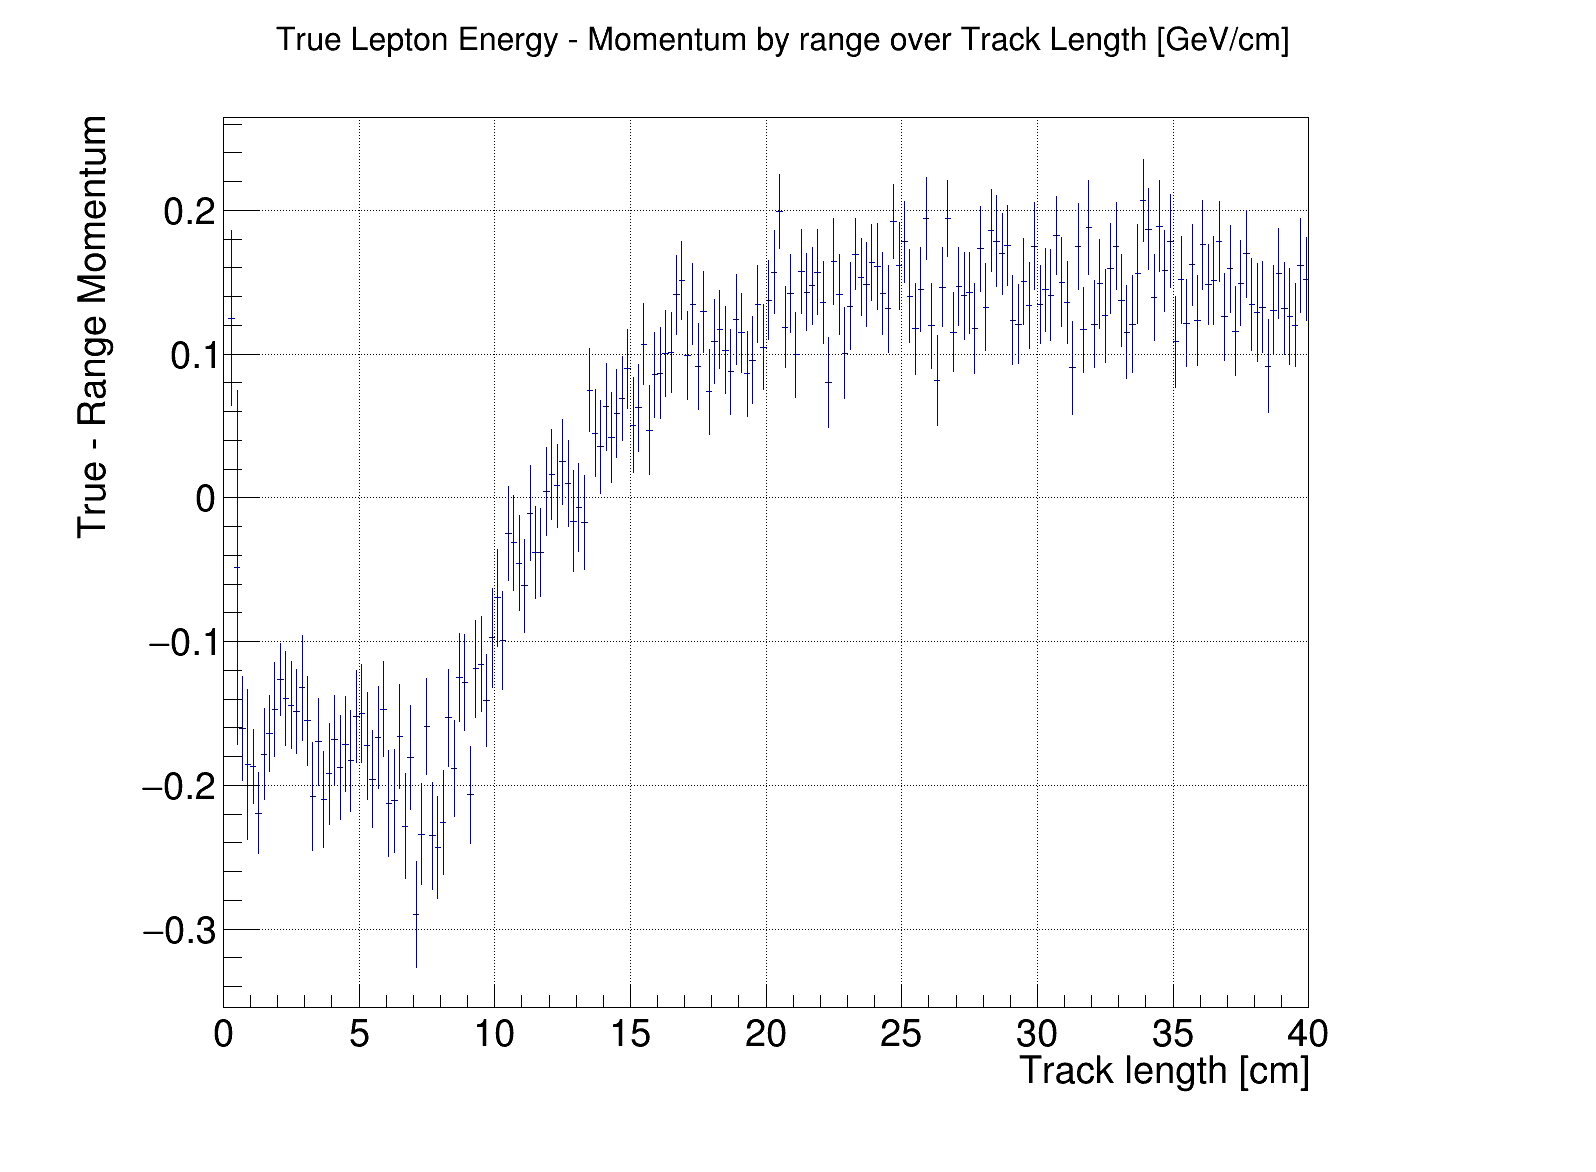

In [19]:
title = '(True lepton momentum - MCS) over track length [GeV/cm]'
xstart = 0
xend = 40
xbin = 200
ystart = -1
yend = 1
ybin = 200
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptFit(0)
#h_pos = ROOT.TH2F("h_pos",title,xbin,xstart,xend,ybin, ystart, yend)
#h_pos = ROOT.TH1F("h_pos",title,xbin,xstart,xend)
h_pos = ROOT.TProfile("h_pos", title, xbin,xstart,xend)
overlay_out.Draw('MCTrackMomentum-TrackMomMCS_mom:TrackLength>>h_pos','muon && TrackMomMCS_mom<6 && fidVol && MCTrackPDG==13 && MCTrackPurity>0.5','profz')
h_pos.SetXTitle("Track length [cm]")
h_pos.SetYTitle("True - MCS Momentum")

h_pos.Draw('')
c1.Draw()
c1.SaveAs(outputdir_png + "h_MCS_tracklength.png")
c1.SaveAs(outputdir_root + "h_MCS_tracklength.root")

title = 'True Lepton Energy - Momentum by range over Track Length [GeV/cm]'
h_pos = ROOT.TProfile("h_pos", title, xbin,xstart,xend)
overlay_out.Draw('MCTrackMomentum-TrackMomRange_mu:TrackLength>>h_pos','muon && TrackMomRange_mu<6 && fidVol','profz')
h_pos.SetXTitle("Track length [cm]")
h_pos.SetYTitle("True - Range Momentum")

h_pos.Draw('')
c1.Draw()
c1.SaveAs(outputdir_png + "h_range_tracklength.png")
c1.SaveAs(outputdir_root + "h_range_tracklength.root")

In [17]:
NuCC.pdg_content33_out('fidVol && muon')

Total number of entries:  279746.0
PDG:  13 	=	65.5% ,	error: 0.2% ,	number:  183159.0
PDG:  2212 	=	12.5% ,	error: 0.1% ,	number:  34855.0
PDG:  -1 	=	9.5% ,	error: 0.1% ,	number:  26453.0
PDG:  11 	=	3.7% ,	error: 0.0% ,	number:  10326.0
PDG:  211 	=	3.7% ,	error: 0.0% ,	number:  10247.0
PDG:  -211 	=	2.1% ,	error: 0.0% ,	number:  5982.0
PDG:  -11 	=	1.3% ,	error: 0.0% ,	number:  3551.0
PDG:  2112 	=	1.0% ,	error: 0.0% ,	number:  2880.0
PDG:  -13 	=	0.6% ,	error: 0.0% ,	number:  1724.0
PDG:  22 	=	0.0% ,	error: 0.0% ,	number:  92.0
PDG:  321 	=	0.0% ,	error: 0.0% ,	number:  39.0
PDG:  -321 	=	0.0% ,	error: 0.0% ,	number:  1.0


In [14]:
NuCC.printEff_out('fidVol && muon')

Efficiency for cut:  fidVol && muon
Rejection on each sample:
Keep of     ext:	100.00%	 reject:	0.00%
Keep of overlay:	100.00%	 reject:	0.00%
Keep of    dirt:	100.00%	 reject:	0.00%

Efficiency:		67.49%
Purity:			31.38%
Purity*Efficiency	21.18

Amount of     ext:	42.71%
Amount of overlay:	52.68%
Amount of    dirt:	4.61%

Signal definition=  numu_lowpur: 3.02%	(5.74%)
Signal definition=   numu_other: 0.47%	(0.90%)
Signal definition=    numu_nomu: 2.49%	(4.73%)
Signal definition=      numu_ov: 8.52%	(16.17%)
Signal definition=  numu_signal: 31.38%	(59.56%)
Signal definition=      numu_nc: 6.80%	(12.90%)


In [41]:
NuCC.printEff_out('fidVol && muon && TrackLength>8')

Efficiency for cut:  fidVol && muon && TrackLength>8
Rejection on each sample:
Keep of     ext:	94.00%	 reject:	6.00%
Keep of overlay:	95.96%	 reject:	4.04%
Keep of    dirt:	91.66%	 reject:	8.34%

Efficiency:		68.28%
Purity:			35.31%
Purity*Efficiency	24.11

Amount of     ext:	39.22%
Amount of overlay:	56.59%
Amount of    dirt:	4.20%

Signal definition=  numu_lowpur: 3.15%	(5.57%)
Signal definition=   numu_other: 0.47%	(0.83%)
Signal definition=    numu_nomu: 2.67%	(4.71%)
Signal definition=      numu_ov: 8.28%	(14.64%)
Signal definition=  numu_signal: 35.31%	(62.40%)
Signal definition=      numu_nc: 6.71%	(11.85%)


In [14]:
NuCC.printEff_out('fidVol && muon && TrackLength>8 && nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut')

Efficiency for cut:  fidVol && muon && TrackLength>8 && nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut
Rejection on each sample:
Keep of     ext:	43.08%	 reject:	56.92%
Keep of overlay:	80.90%	 reject:	19.10%
Keep of    dirt:	54.23%	 reject:	45.77%

Efficiency:		60.82%
Purity:			46.14%
Purity*Efficiency	28.06

Amount of     ext:	26.37%
Amount of overlay:	69.99%
Amount of    dirt:	3.64%

Signal definition=  numu_lowpur: 3.11%	(4.45%)
Signal definition=   numu_other: 0.61%	(0.87%)
Signal definition=    numu_nomu: 3.06%	(4.37%)
Signal definition=      numu_ov: 8.32%	(11.89%)
Signal definition=  numu_signal: 46.14%	(65.92%)
Signal definition=      numu_nc: 8.75%	(12.50%)


In [11]:
NuCC.printEff_out('fidVol && muon &&  TrackLength>8 && nr_crthit_top==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut')

Efficiency for cut:  fidVol && muon &&  TrackLength>8 && nr_crthit_top==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut
Rejection on each sample:
Keep of     ext:	44.97%	 reject:	55.03%
Keep of overlay:	81.28%	 reject:	18.72%
Keep of    dirt:	59.65%	 reject:	40.35%

Efficiency:		61.02%
Purity:			45.46%
Purity*Efficiency	27.74

Amount of     ext:	27.03%
Amount of overlay:	69.04%
Amount of    dirt:	3.93%

Signal definition=  numu_lowpur: 3.07%	(4.44%)
Signal definition=   numu_other: 0.60%	(0.87%)
Signal definition=    numu_nomu: 3.01%	(4.36%)
Signal definition=      numu_ov: 8.32%	(12.04%)
Signal definition=  numu_signal: 45.46%	(65.84%)
Signal definition=      numu_nc: 8.60%	(12.45%)


In [43]:
NuCC.pdg_content33_out('fidVol && muon && TrackLength>32 && nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut')

Total number of entries:  188041.0
PDG:  13 	=	80.3% ,	error: 0.2% ,	number:  150918.0
PDG:  2212 	=	6.8% ,	error: 0.1% ,	number:  12821.0
PDG:  -1 	=	4.3% ,	error: 0.0% ,	number:  8092.0
PDG:  211 	=	3.3% ,	error: 0.0% ,	number:  6144.0
PDG:  11 	=	1.8% ,	error: 0.0% ,	number:  3373.0
PDG:  -211 	=	1.7% ,	error: 0.0% ,	number:  3160.0
PDG:  -13 	=	0.8% ,	error: 0.0% ,	number:  1466.0
PDG:  2112 	=	0.7% ,	error: 0.0% ,	number:  1259.0
PDG:  -11 	=	0.3% ,	error: 0.0% ,	number:  593.0
PDG:  22 	=	0.0% ,	error: 0.0% ,	number:  45.0
PDG:  321 	=	0.0% ,	error: 0.0% ,	number:  31.0


In [13]:
crt_tom_cut = 'nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut'

data.SetAlias("crt_tom_cut",crt_tom_cut)
ext.SetAlias("crt_tom_cut",crt_tom_cut)
overlay.SetAlias("crt_tom_cut",crt_tom_cut)
dirt.SetAlias("crt_tom_cut",crt_tom_cut)
data_out.SetAlias("crt_tom_cut",crt_tom_cut)
ext_out.SetAlias("crt_tom_cut",crt_tom_cut)
overlay_out.SetAlias("crt_tom_cut",crt_tom_cut)
dirt_out.SetAlias("crt_tom_cut",crt_tom_cut)


True

In [45]:
NuCC.printEff_out('fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8')

Efficiency for cut:  fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8
Rejection on each sample:
Keep of     ext:	39.58%	 reject:	60.42%
Keep of overlay:	76.63%	 reject:	23.37%
Keep of    dirt:	48.17%	 reject:	51.83%

Efficiency:		59.36%
Purity:			48.04%
Purity*Efficiency	28.52

Amount of     ext:	25.84%
Amount of overlay:	70.71%
Amount of    dirt:	3.45%

Signal definition=  numu_lowpur: 2.86%	(4.05%)
Signal definition=   numu_other: 0.60%	(0.85%)
Signal definition=    numu_nomu: 3.11%	(4.40%)
Signal definition=      numu_ov: 7.89%	(11.16%)
Signal definition=  numu_signal: 48.04%	(67.94%)
Signal definition=      numu_nc: 8.20%	(11.60%)


In [46]:
#NuCC.printEff_out('fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8 && TrackLength>20')

In [47]:
NuCC.printEff_out('fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8 && TrackLength>32')
# 20cm = 150MeV MC momentum, 32 = 180 MeV, 25cm = 160MeV, 15cm = 130MeV, 10 = 115MeV, 8cm=100MeV

Efficiency for cut:  fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8 && TrackLength>32
Rejection on each sample:
Keep of     ext:	34.85%	 reject:	65.15%
Keep of overlay:	66.61%	 reject:	33.39%
Keep of    dirt:	36.86%	 reject:	63.14%

Efficiency:		56.80%
Purity:			52.92%
Purity*Efficiency	30.06

Amount of     ext:	26.19%
Amount of overlay:	70.77%
Amount of    dirt:	3.04%

Signal definition=  numu_lowpur: 2.77%	(3.91%)
Signal definition=   numu_other: 0.58%	(0.82%)
Signal definition=    numu_nomu: 2.72%	(3.84%)
Signal definition=      numu_ov: 7.12%	(10.06%)
Signal definition=  numu_signal: 52.92%	(74.78%)
Signal definition=      numu_nc: 4.67%	(6.59%)


In [48]:
NuCC.printEff_out('fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>32 && TrackPID_chimuon<24')

Efficiency for cut:  fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8                && TrackLength>32 && TrackPID_chimuon<24
Rejection on each sample:
Keep of     ext:	33.73%	 reject:	66.27%
Keep of overlay:	63.52%	 reject:	36.48%
Keep of    dirt:	35.56%	 reject:	64.44%

Efficiency:		55.95%
Purity:			54.43%
Purity*Efficiency	30.45

Amount of     ext:	26.47%
Amount of overlay:	70.47%
Amount of    dirt:	3.06%

Signal definition=  numu_lowpur: 2.64%	(3.75%)
Signal definition=   numu_other: 0.56%	(0.79%)
Signal definition=    numu_nomu: 2.37%	(3.36%)
Signal definition=      numu_ov: 7.06%	(10.02%)
Signal definition=  numu_signal: 54.43%	(77.24%)
Signal definition=      numu_nc: 3.41%	(4.84%)


In [49]:
NuCC.printEff_out('fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>32 && TrackPID_chimuon<30')

Efficiency for cut:  fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8                && TrackLength>32 && TrackPID_chimuon<30
Rejection on each sample:
Keep of     ext:	34.27%	 reject:	65.73%
Keep of overlay:	64.33%	 reject:	35.67%
Keep of    dirt:	36.06%	 reject:	63.94%

Efficiency:		56.36%
Purity:			54.09%
Purity*Efficiency	30.48

Amount of     ext:	26.53%
Amount of overlay:	70.40%
Amount of    dirt:	3.06%

Signal definition=  numu_lowpur: 2.71%	(3.85%)
Signal definition=   numu_other: 0.56%	(0.80%)
Signal definition=    numu_nomu: 2.39%	(3.39%)
Signal definition=      numu_ov: 7.10%	(10.08%)
Signal definition=  numu_signal: 54.09%	(76.83%)
Signal definition=      numu_nc: 3.56%	(5.05%)


In [59]:
NuCC.printEff_out('fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>10 && TrackPID_chimuon<30 && NuScore>0.1')

Efficiency for cut:  fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8                && TrackLength>10 && TrackPID_chimuon<30 && NuScore>0.1
Rejection on each sample:
Keep of     ext:	11.83%	 reject:	88.17%
Keep of overlay:	58.67%	 reject:	41.33%
Keep of    dirt:	20.55%	 reject:	79.45%

Efficiency:		52.49%
Purity:			66.13%
Purity*Efficiency	34.71

Amount of     ext:	13.69%
Amount of overlay:	83.74%
Amount of    dirt:	2.57%

Signal definition=  numu_lowpur: 2.62%	(3.13%)
Signal definition=   numu_other: 0.73%	(0.87%)
Signal definition=    numu_nomu: 3.29%	(3.93%)
Signal definition=      numu_ov: 5.60%	(6.69%)
Signal definition=  numu_signal: 66.13%	(78.97%)
Signal definition=      numu_nc: 5.37%	(6.42%)


In [14]:
NuCC.pdg_content33_out('fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chimuon<30 && NuScore>0.1 && MCTrackPurity>0.5')

Total number of entries:  159944.0
PDG:  13 	=	90.0% ,	error: 0.2% ,	number:  143877.0
PDG:  211 	=	3.7% ,	error: 0.0% ,	number:  5843.0
PDG:  2212 	=	3.5% ,	error: 0.0% ,	number:  5602.0
PDG:  -211 	=	1.9% ,	error: 0.0% ,	number:  2999.0
PDG:  -13 	=	0.8% ,	error: 0.0% ,	number:  1359.0
PDG:  11 	=	0.1% ,	error: 0.0% ,	number:  145.0
PDG:  -11 	=	0.1% ,	error: 0.0% ,	number:  97.0
PDG:  321 	=	0.0% ,	error: 0.0% ,	number:  19.0
PDG:  -321 	=	0.0% ,	error: 0.0% ,	number:  1.0


MC entries, scaled:  70.6980508921
MC entries, scaled:  13.7379325565
MC entries, scaled:  67.8877022524
MC entries, scaled:  196.305990591
MC entries, scaled:  1027.40209527
MC entries, scaled:  192.589077874
Normalization (data-ext)/mc =  1.10902106147
Normalization (data)/(mc +ext) =  1.08178539704


Warning in <TROOT::Append>: Replacing existing TH1: h_ext_func (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_dirt_func (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_lowpur (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_other (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_nomu (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_ov (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_signal (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_nc (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/muon_cut//png/NuScore_muon_cut.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35

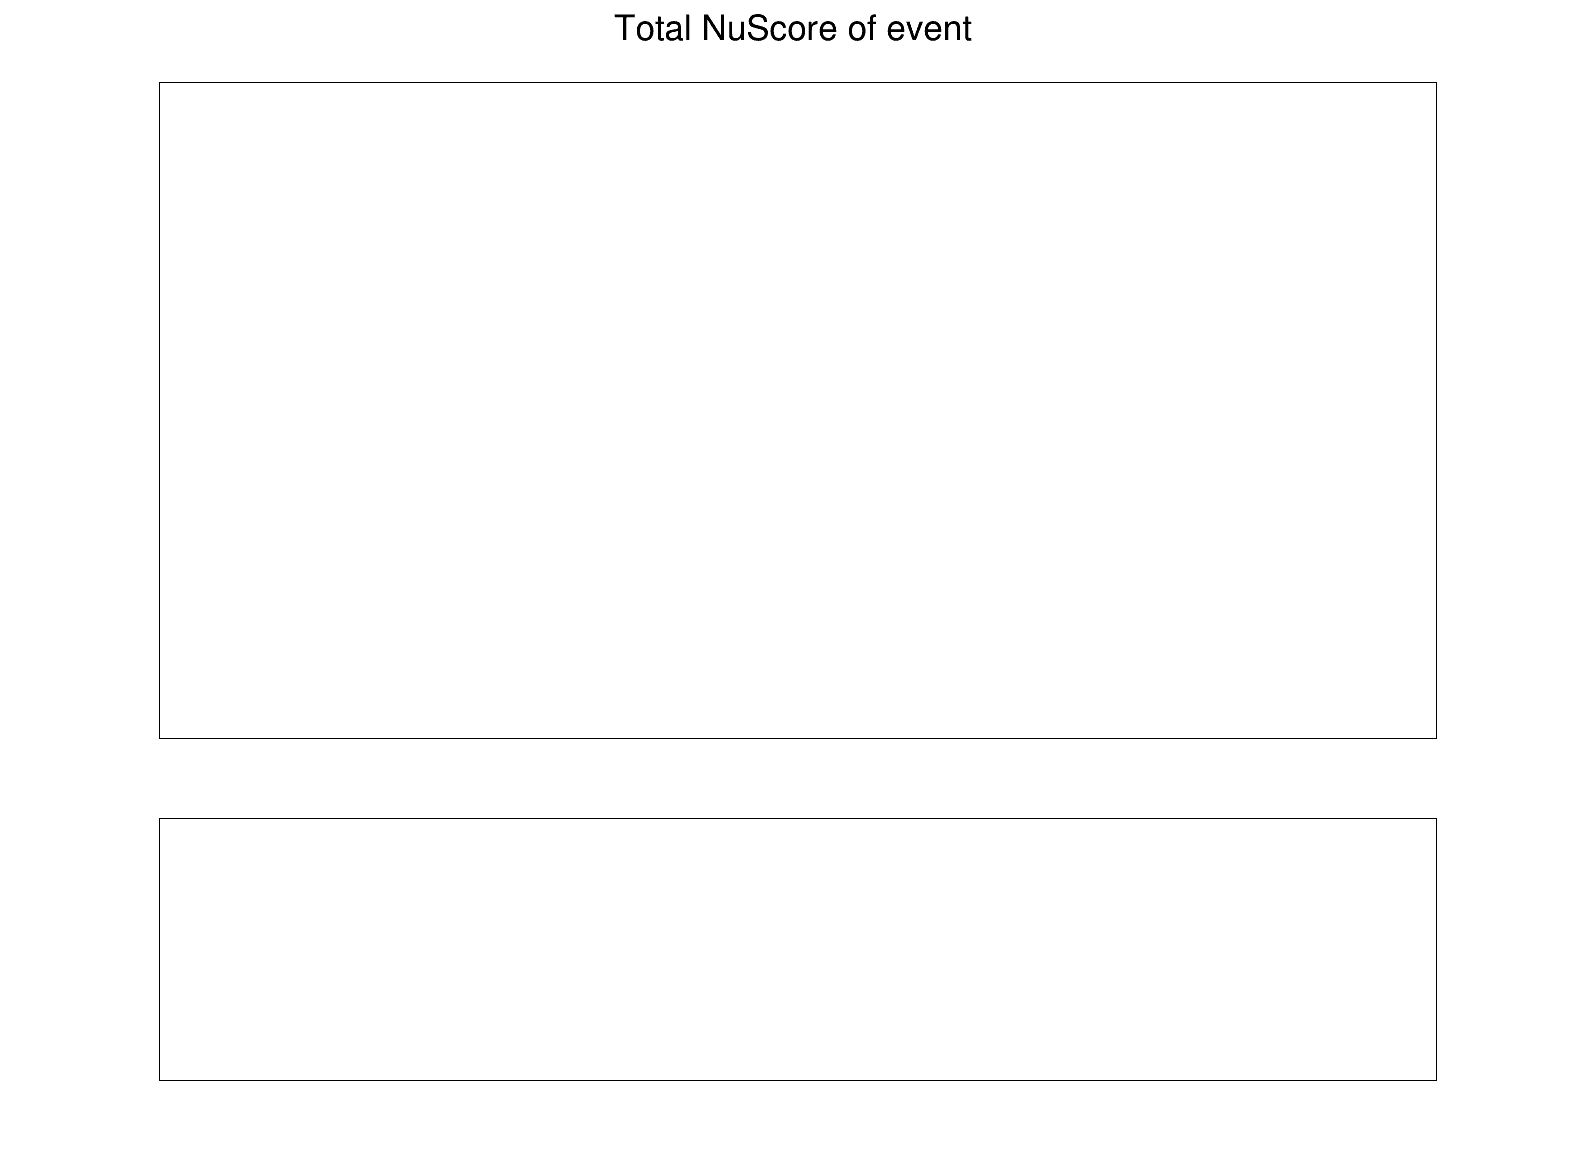

In [13]:
cut = 'fidVol && muon && crt_tom_cut\
                && TrackLength>8'
name = '_muon_cut'
#NuCC.make_stacked_histo_plot_out(cut + ' && TrackTheta!=-9','cos(TrackTheta)','cos(theta)',-1,1,20,'costheta'+name)
#NuCC.make_stacked_histo_plot_out(cut + ' && 1','TrackMomMCS_mom','MCS track Momentum [GeV]',0,1.5,20,'MCSTrack'+name)
#NuCC.make_stacked_histo_plot_out(cut + ' && TrackPhi!=-9','TrackPhi','Track Phi',-3.141,3.141,20,'TrackPhi'+name)
#NuCC.make_stacked_histo_plot_out(cut,'Nu_Vz_sce','Reco. Nu vertex Z position [cm]',-20,1020,52,'NuVz_sce'+name)
#NuCC.make_stacked_histo_plot_out(cut,'Nu_Vy_sce','Reco. Nu vertex Y position [cm]',-150,150,30,'NuVy_sce'+name)
#NuCC.make_stacked_histo_plot_out(cut,'Nu_Vx_sce','Reco. Nu vertex X position [cm]',-10,270,28,'NuVx_sce'+name)
NuCC.make_stacked_histo_plot_out(cut,'NuScore','Total NuScore of event',0,1,20,'NuScore'+name)

In [55]:
nenner = 'numu_true'
zahler = 'fidVol && muon && numu_signal'
cut = 'fidVol && muon'
NuCC.plot_eff_outV2(nenner,zahler,cut,'initial','initial')

Efficiency:	67.49%
Purity:		31.38%


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//png/h_eff_energyinitialV0.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//root/h_eff_energyinitialV0.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//png/h_eff_thetainitialV0.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//root/h_eff_thetainitialV0.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//png/h_eff_phiinitialV0.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//root/h_eff_phiinitialV0.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//png/h_eff_VxinitialV0.png has been created
Info in <TCan

In [58]:
nenner = 'numu_true'
zahler = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chimuon<30 && numu_true'
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chimuon<30'
NuCC.plot_eff_outV2(nenner,zahler,cut,'crt_muon_tot','crt_muon_tot')

Efficiency:	57.07%
Purity:		52.04%


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//png/h_eff_energycrt_muon_tot.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//root/h_eff_energycrt_muon_tot.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//png/h_eff_thetacrt_muon_tot.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//root/h_eff_thetacrt_muon_tot.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//png/h_eff_phicrt_muon_tot.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//root/h_eff_phicrt_muon_tot.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//png/h_eff_Vxcrt_muon_tot.png has been 

In [57]:
nenner = 'numu_true && fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
             && TrackPID_chimuon<30'
zahler = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chimuon<30 && numu_true'
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chimuon<30'
NuCC.plot_eff_outV2(nenner,zahler,cut,'crt_muon_tracklength','crt_muon_tracklength')

Efficiency:	57.07%
Purity:		52.04%


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//png/h_eff_energycrt_muon_tracklength.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//root/h_eff_energycrt_muon_tracklength.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//png/h_eff_thetacrt_muon_tracklength.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//root/h_eff_thetacrt_muon_tracklength.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//png/h_eff_phicrt_muon_tracklength.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//root/h_eff_phicrt_muon_tracklength.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/

In [56]:
nenner = 'fidVol && muon && numu_true && crt_tom_cut'
zahler = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chimuon<30 && numu_true'
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chimuon<30'
NuCC.plot_eff_outV2(nenner,zahler,cut,'crt_muon_only','crt_muon_only')

Efficiency:	57.07%
Purity:		52.04%


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//png/h_eff_energycrt_muon_only.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//root/h_eff_energycrt_muon_only.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//png/h_eff_thetacrt_muon_only.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//root/h_eff_thetacrt_muon_only.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//png/h_eff_phicrt_muon_only.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//root/h_eff_phicrt_muon_only.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//png/h_eff_Vxcrt_muon_only.png ha

In [57]:
nenner = 'fidVol && muon && numu_true'
zahler = 'fidVol && muon && TrackLength>8 && crt_tom_cut && numu_true'
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut'
NuCC.plot_eff_outV2(nenner,zahler,cut,'crt_only','crt_only')

Efficiency:	60.75%
Purity:		46.04%


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_17/muon_cut_MCscale//png/h_eff_energycrt_only.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_17/muon_cut_MCscale//root/h_eff_energycrt_only.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_17/muon_cut_MCscale//png/h_eff_thetacrt_only.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_17/muon_cut_MCscale//root/h_eff_thetacrt_only.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_17/muon_cut_MCscale//png/h_eff_phicrt_only.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_17/muon_cut_MCscale//root/h_eff_phicrt_only.root has been created
Info in <TCanvas::

In [54]:
nenner = 'numu_true'
zahler = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chimuon<30 && NuScore>0.1 && numu_true'
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chimuon<30 && NuScore>0.1'
NuCC.plot_eff_outV2(nenner,zahler,cut,'all','all')

Efficiency:	56.16%
Purity:		67.62%


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_1 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//png/h_eff_energyallV0.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//root/h_eff_energyallV0.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//png/h_eff_thetaallV0.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//root/h_eff_thetaallV0.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//png/h_eff_phiallV0.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettle

In [18]:
nenner = 'numu_true && fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>32 && TrackPID_chimuon<30'
zahler = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>32 && TrackPID_chimuon<30 && NuScore>0.1 && numu_true'
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>32 && TrackPID_chimuon<30 && NuScore>0.1'
NuCC.plot_eff_outV2(nenner,zahler,cut,'nu_only','nu_only')

Efficiency:	51.23%
Purity:		69.61%


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_17/muon_cut_MCscale//png/h_eff_energynu_only.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_17/muon_cut_MCscale//root/h_eff_energynu_only.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_17/muon_cut_MCscale//png/h_eff_thetanu_only.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_17/muon_cut_MCscale//root/h_eff_thetanu_only.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_17/muon_cut_MCscale//png/h_eff_phinu_only.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_17/muon_cut_MCscale//root/h_eff_phinu_only.root has been created
Info in <TCanvas::Print>

In [15]:
nenner = 'fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackPID_chiproton>78 && NuScore>0.1 && numu_true'
zahler = 'fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1 && numu_true'
cut = 'fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
NuCC.plot_eff_outV2(nenner,zahler,cut,'tracklength','tracklength')

Efficiency:	52.14%
Purity:		68.61%


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//png/h_eff_energytracklength.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//root/h_eff_energytracklength.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//png/h_eff_thetatracklength.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//root/h_eff_thetatracklength.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//png/h_eff_phitracklength.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//root/h_eff_phitracklength.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_

In [ ]:
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

nenner = 'numu_true'
zahler = 'fidVol && numu_true'
zahler2 = zahler+' && muon'
zahler3 = zahler2+' && crt_tom_cut'
zahler4 = zahler3+' && TrackScore>0.8'
zahler5 = zahler4+' && TrackLength>20'
zahler6 = zahler5+' && TrackPID_chimuon<30'
zahler7 = zahler6+' && NuScore<0.1'
zahler8 = zahler7+' && TrackScore>0.8'


xstart = 0
xend = 2
xbin = 100
title = 'Efficiency'
h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,xbin,xstart,xend)
h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,xbin,xstart,xend)
globale.overlay_out.Draw('MCNu_Energy>>h_init_eff_energy',zahler)
globale.overlay_out.Draw('MCNu_Energy>>h_init_eff_energy_1',nenner)
eff =  ROOT.TEfficiency(h_init_eff_energy,h_init_eff_energy_1)
eff.SetStatisticOption(ROOT.TEfficiency.kFCP)#;  // to set option for errors (see ref doc)
eff.SetConfidenceLevel(0.68)

globale.overlay_out.Draw('MCNu_Energy>>h_init_eff_energy',zahler2)
#globale.overlay_out.Draw('MCNu_Energy>>h_init_eff_energy_1',nenner_cut)
eff2 =  ROOT.TEfficiency(h_init_eff_energy,h_init_eff_energy_1)
eff2.SetStatisticOption(ROOT.TEfficiency.kFCP)#;  // to set option for errors (see ref doc)
eff2.SetConfidenceLevel(0.68)



eff.SetTitle(title)
eff.Draw("AP")
eff2.Draw("same AP")

ROOT.gPad.Update()
graph = eff.GetPaintedGraph()
graph.SetMinimum(0)
graph.SetMaximum(1)
graph.SetLineWidth(2)
graph.GetXaxis().SetTitle("Truth neutrino energy [GeV]")
graph.GetYaxis().SetTitle("Signal efficiency")
graph.Draw("AP")
graph = eff2.GetPaintedGraph()
graph.Draw("same AP")
#graph1 = graph.Clone()
#graph.SetFillColor(2);
#graph.SetFillStyle(1001);
#graph.Draw("a4");
#graph1.Draw("same")
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_eff_energy_cuts.png")
c1.SaveAs(globale.outputdir_root + "h_eff_energy_cuts.root")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_init_eff_energy_12 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//png/h_eff_energy.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//root/h_eff_energy.root has been created


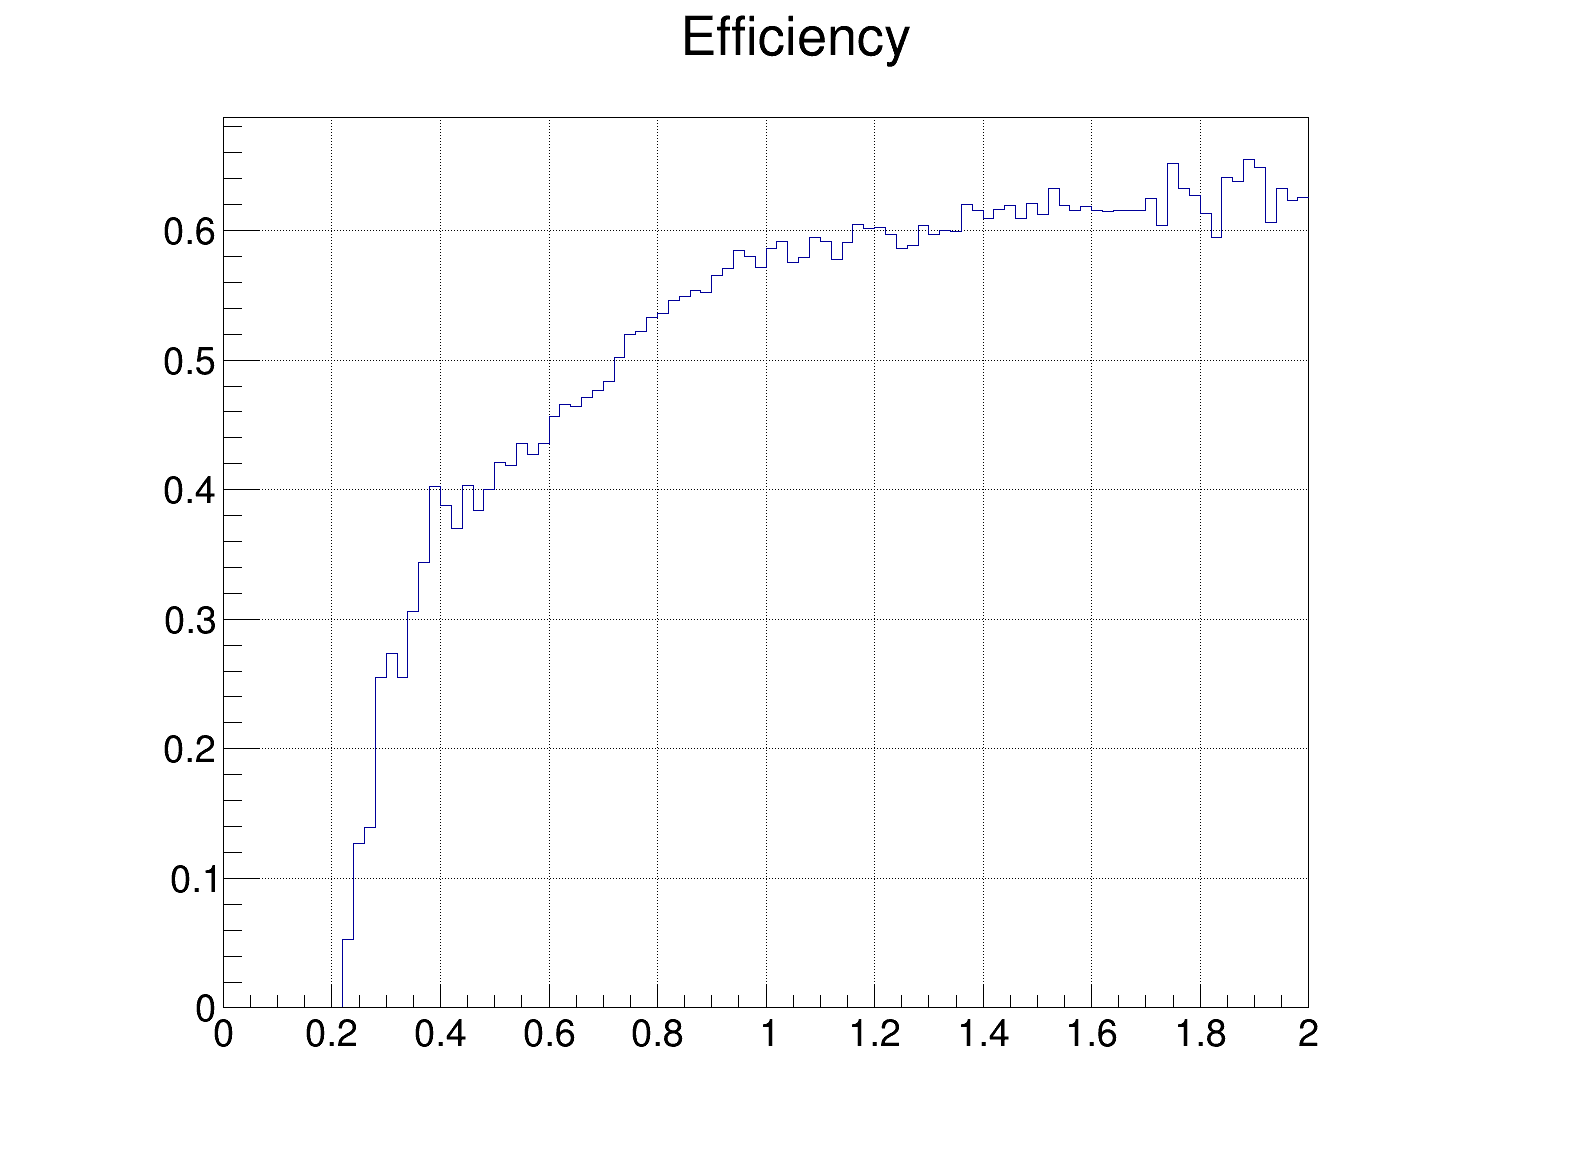

In [53]:
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

nenner = 'numu_true'
zahler = 'fidVol && numu_true'
zahler2 = zahler+' && muon'
zahler3 = zahler2+' && crt_tom_cut'
zahler4 = zahler3+' && TrackScore>0.8'
zahler5 = zahler4+' && TrackLength>20'
zahler6 = zahler5+' && TrackPID_chimuon<30'
zahler7 = zahler6+' && NuScore>0.1'
zahler8 = zahler7+' && TrackScore>0.8'

title = 'Efficiency'

xstart = 0
xend = 2
xbin = 100

h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,xbin,xstart,xend)
h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,xbin,xstart,xend)
globale.overlay_out.Draw('MCNu_Energy>>h_init_eff_energy',zahler)
globale.overlay_out.Draw('MCNu_Energy>>h_init_eff_energy_1',nenner)
#h_init_eff_energy_1.Sumw2()
h_init_eff_energy.Divide(h_init_eff_energy_1)
#h_init_eff_energy.Scale(100)
#h_init_eff_energy.SetMaximum(100)
#h_init_eff_energy.SetMinimum(0)
h_init_eff_energy.SetXTitle("Truth neutrino energy [GeV]")
h_init_eff_energy.SetYTitle("Signal efficiency [%]")
h_init_eff_energy.Draw("")

h_init_eff_energy2 = ROOT.TH1F("h_init_eff_energy2",title,xbin,xstart,xend)
h_init_eff_energy_12 = ROOT.TH1F("h_init_eff_energy_12",title,xbin,xstart,xend)
globale.overlay_out.Draw('MCNu_Energy>>h_init_eff_energy2',zahler8)
globale.overlay_out.Draw('MCNu_Energy>>h_init_eff_energy_12',nenner)
#h_init_eff_energy_12.Sumw2()
h_init_eff_energy2.Divide(h_init_eff_energy_12)
#h_init_eff_energy2.Scale(100)
#h_init_eff_energy2.SetMaximum(100)
#h_init_eff_energy2.SetMinimum(0)
h_init_eff_energy2.Draw("")

c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_eff_energy.png")
c1.SaveAs(globale.outputdir_root + "h_eff_energy.root")


In [26]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


Variation of cut on: TrackLength
Maximum value:  35.995880127
Bin:  21  -> Value:  20.0


Warning in <TROOT::Append>: Replacing existing TH1: h_eff (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_pur (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_effpur (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_17/muon_cut_MCscale//png/TrackLength.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_17/muon_cut_MCscale//root/TrackLength.root has been created


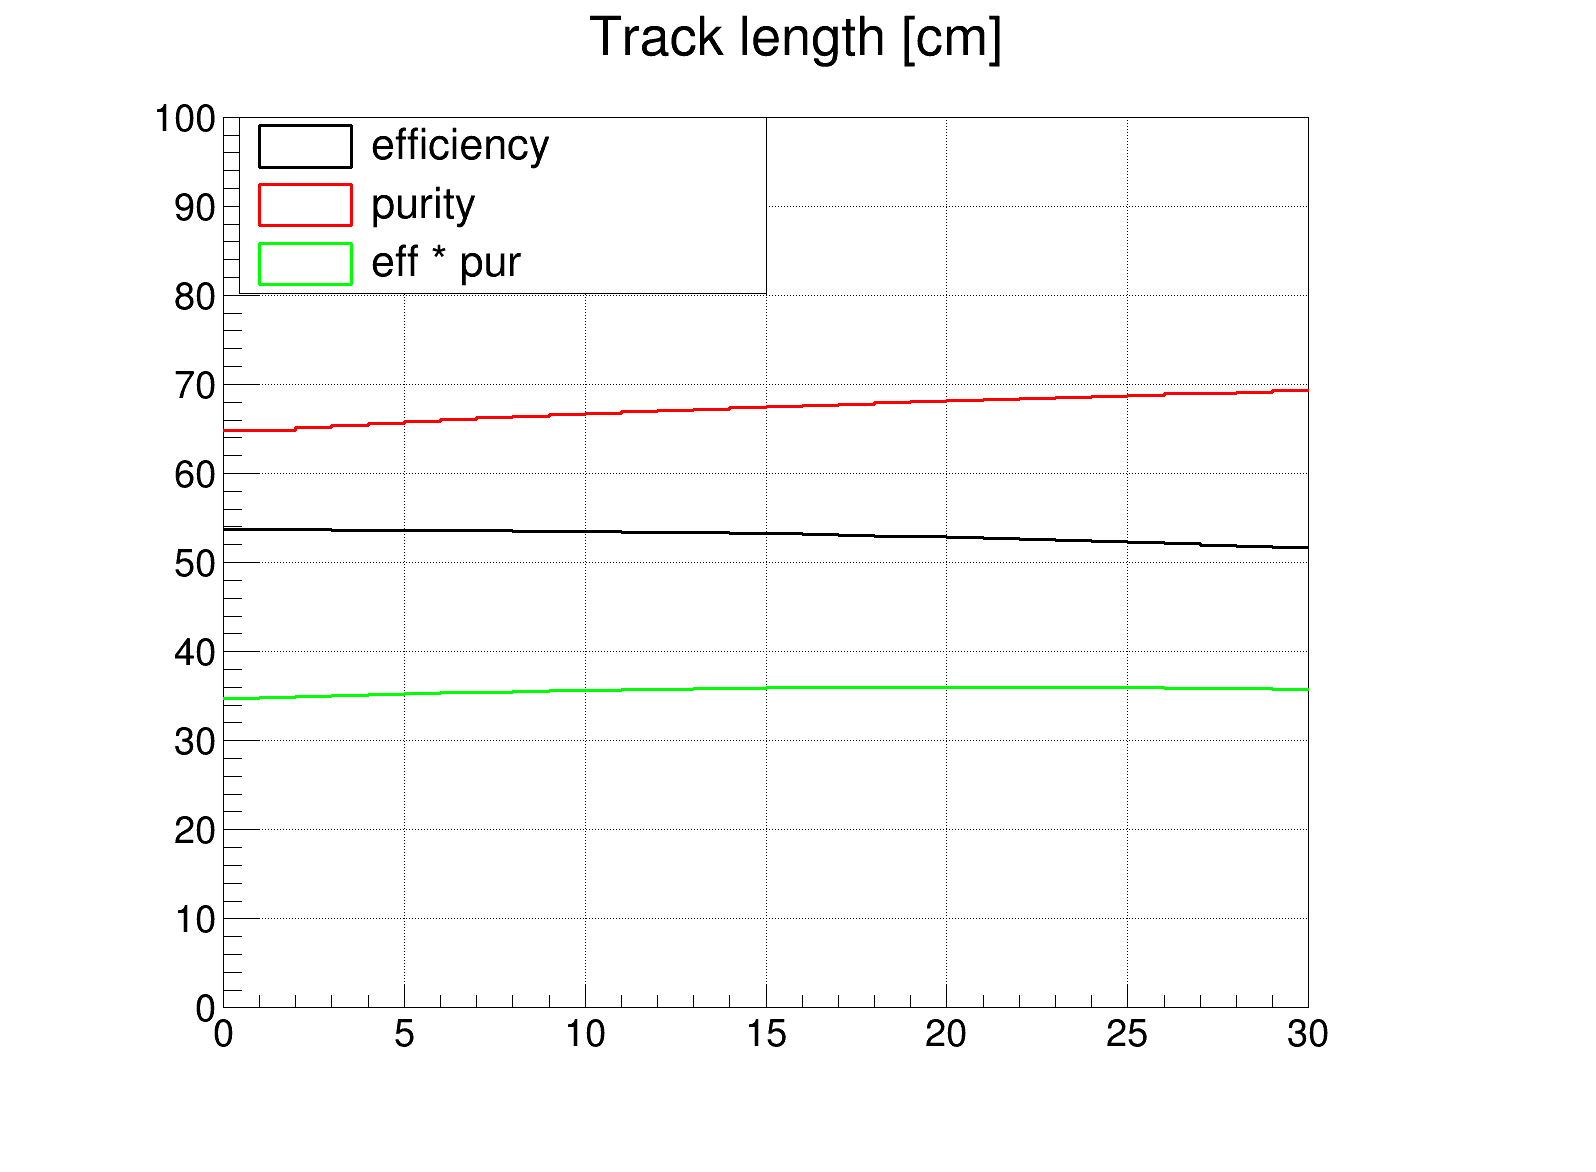

In [22]:
value = 'TrackLength'
xbins = 30
xstart = 0
xend = 30
step = (xend-xstart)/xbins
title = 'Track length [cm]'

h_eff =  ROOT.TH1F("h_eff",title,xbins,xstart,xend)
h_pur = ROOT.TH1F("h_pur",title,xbins,xstart,xend)
h_effpur = ROOT.TH1F("h_effpur",title,xbins,xstart,xend)
for i in range(xbins): 
    cut = 'muon && fidVol && TrackPID_chimuon<30 && NuScore>0.1 && crt_tom_cut && TrackScore>0.8 && ('+value+'>('+str(xstart)+'+'+str(step)+'*'+str(i)+'))'
    #print cut
    pur = overlay_out.GetEntries(cut+' && numu_signal')*scale[overlay]*100.0/(NuCC.getTotNum_out(cut)+0.00001)
    eff = overlay_out.GetEntries(cut+' && numu_signal')*100.0/overlay_out.GetEntries("numu_true")
    h_eff.SetBinContent(i+1,eff)
    h_pur.SetBinContent(i+1,pur)
    h_effpur.SetBinContent(i+1,eff*pur/100.0)
    #print eff ,pur, eff*pur,i

legend = ROOT.TLegend(0.15,0.75,0.48,0.9);
legend.AddEntry(h_eff,"efficiency","f");
legend.AddEntry(h_pur,"purity","f");
legend.AddEntry(h_effpur,"eff * pur","f");

h_eff.SetLineColor(1)
h_eff.SetMaximum(100)
h_eff.SetMinimum(0)
h_pur.SetLineColor(2)
h_effpur.SetLineColor(3)
h_pur.SetLineWidth(3)
h_eff.SetLineWidth(3)
h_effpur.SetLineWidth(3)
h_eff.Draw()
legend.Draw()
h_pur.Draw('same')
h_effpur.Draw('same')
h_eff.Draw('same')
c1.SetLogy(0)
c1.Draw()
c1.SaveAs(outputdir_png+ value +".png");
c1.SaveAs(outputdir_root+ value+ ".root");

print 'Variation of cut on: '+value
print 'Maximum value: ', h_effpur.GetMaximum()
print 'Bin: ', h_effpur.GetMaximumBin(),' -> Value: ', xstart+(h_effpur.GetMaximumBin()-1)*step

Variation of cut on: TrackPID_chimuon
Maximum value:  36.0090904236
Bin:  29  -> Value:  28.0


Warning in <TROOT::Append>: Replacing existing TH1: h_eff (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_pur (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_effpur (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_17/muon_cut_MCscale//png/TrackPID_chimuon.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_17/muon_cut_MCscale//root/TrackPID_chimuon.root has been created


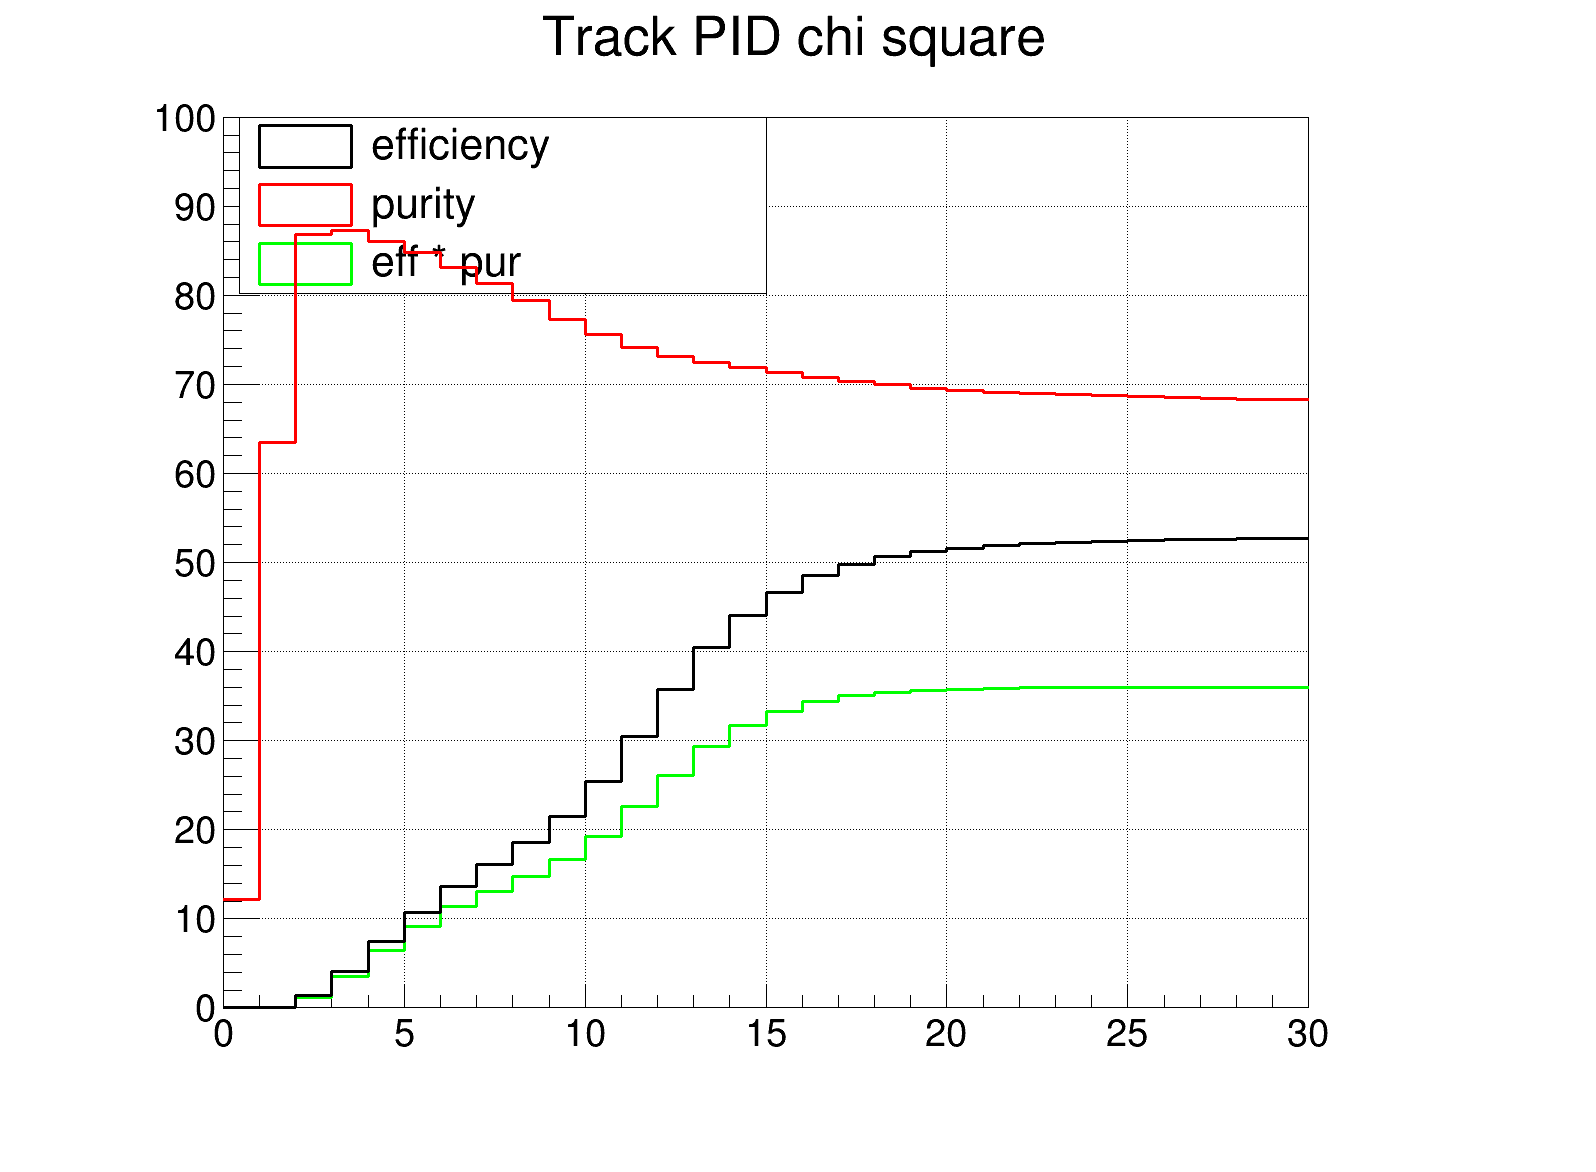

In [27]:
value = 'TrackPID_chimuon'
xbins = 30
xstart = 0
xend = 30
step = (xend-xstart)/xbins
title = 'Track PID chi square'

h_eff =  ROOT.TH1F("h_eff",title,xbins,xstart,xend)
h_pur = ROOT.TH1F("h_pur",title,xbins,xstart,xend)
h_effpur = ROOT.TH1F("h_effpur",title,xbins,xstart,xend)
for i in range(xbins): 
    cut = 'muon && fidVol && crt_tom_cut && TrackScore>0.8 && \
        TrackLength>20 && NuScore>0.1 && ('+value+'<('+str(xstart)+'+'+str(step)+'*'+str(i)+'))'
    #print cut
    pur = overlay_out.GetEntries(cut+' && numu_signal')*scale[overlay]*100.0/(NuCC.getTotNum_out(cut)+0.00001)
    eff = overlay_out.GetEntries(cut+' && numu_signal')*100.0/overlay_out.GetEntries("numu_true")
    h_eff.SetBinContent(i+1,eff)
    h_pur.SetBinContent(i+1,pur)
    h_effpur.SetBinContent(i+1,eff*pur/100.0)
    #print eff ,pur, eff*pur,i

legend = ROOT.TLegend(0.15,0.75,0.48,0.9);
legend.AddEntry(h_eff,"efficiency","f");
legend.AddEntry(h_pur,"purity","f");
legend.AddEntry(h_effpur,"eff * pur","f");

h_eff.SetLineColor(1)
h_eff.SetMaximum(100)
h_eff.SetMinimum(0)
h_pur.SetLineColor(2)
h_effpur.SetLineColor(3)
h_pur.SetLineWidth(3)
h_eff.SetLineWidth(3)
h_effpur.SetLineWidth(3)
h_eff.Draw()
legend.Draw()
h_pur.Draw('same')
h_effpur.Draw('same')
h_eff.Draw('same')
c1.SetLogy(0)
c1.Draw()
c1.SaveAs(outputdir_png+ value +".png");
c1.SaveAs(outputdir_root+ value+ ".root");

print 'Variation of cut on: '+value
print 'Maximum value: ', h_effpur.GetMaximum()
print 'Bin: ', h_effpur.GetMaximumBin(),' -> Value: ', xstart+(h_effpur.GetMaximumBin()-1)*step

Variation of cut on: TrackPID_chiproton
Maximum value:  35.7732086182
Bin:  10  -> Value:  78.0


Warning in <TROOT::Append>: Replacing existing TH1: h_eff (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_pur (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_effpur (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//png/TrackPID_chiproton.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/muon_cut//root/TrackPID_chiproton.root has been created


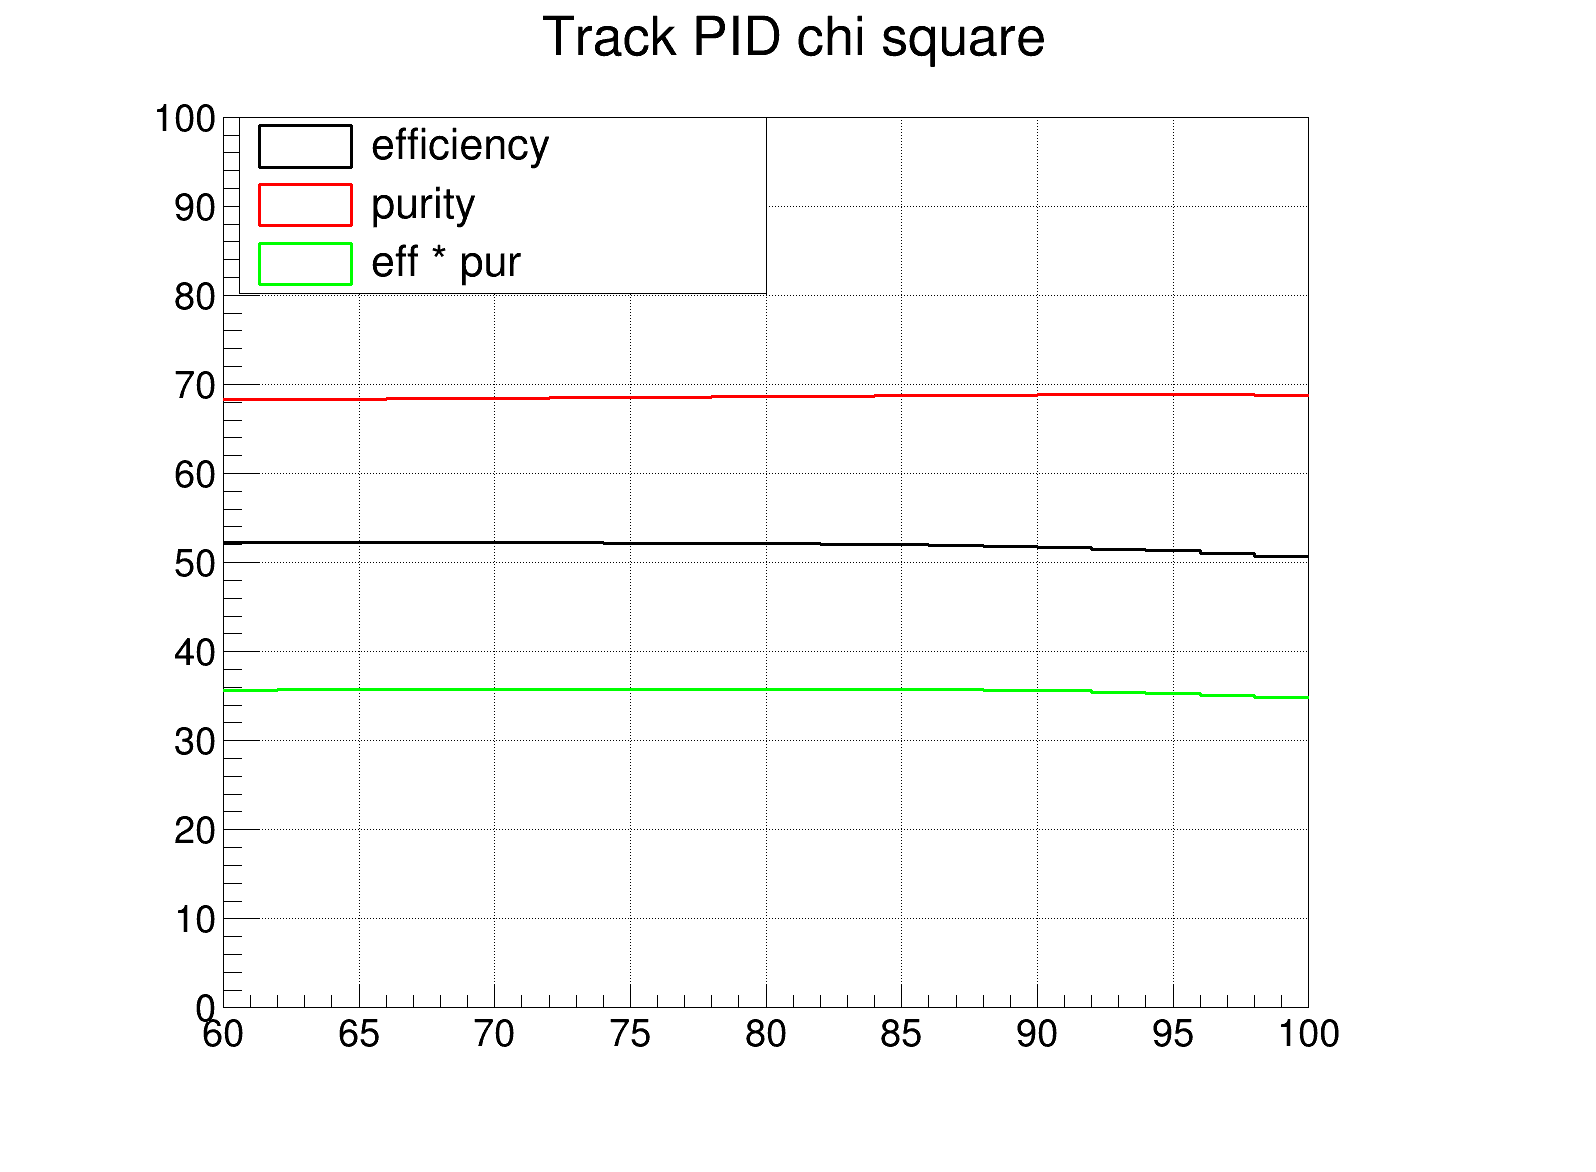

In [14]:
value = 'TrackPID_chiproton'
xbins = 20
xstart = 60
xend = 100
step = (xend-xstart)/xbins
title = 'Track PID chi square'

h_eff =  ROOT.TH1F("h_eff",title,xbins,xstart,xend)
h_pur = ROOT.TH1F("h_pur",title,xbins,xstart,xend)
h_effpur = ROOT.TH1F("h_effpur",title,xbins,xstart,xend)
for i in range(xbins): 
    cut = 'muon && fidVol && crt_tom_cut && TrackScore>0.8 && \
        TrackLength>20 && NuScore>0.1 && ('+value+'>('+str(xstart)+'+'+str(step)+'*'+str(i)+'))'
    #print cut
    pur = overlay_out.GetEntries(cut+' && numu_signal')*scale[overlay]*100.0/(NuCC.getTotNum_out(cut)+0.00001)
    eff = overlay_out.GetEntries(cut+' && numu_signal')*100.0/overlay_out.GetEntries("numu_true")
    h_eff.SetBinContent(i+1,eff)
    h_pur.SetBinContent(i+1,pur)
    h_effpur.SetBinContent(i+1,eff*pur/100.0)
    #print eff ,pur, eff*pur,i

legend = ROOT.TLegend(0.15,0.75,0.48,0.9);
legend.AddEntry(h_eff,"efficiency","f");
legend.AddEntry(h_pur,"purity","f");
legend.AddEntry(h_effpur,"eff * pur","f");

h_eff.SetLineColor(1)
h_eff.SetMaximum(100)
h_eff.SetMinimum(0)
h_pur.SetLineColor(2)
h_effpur.SetLineColor(3)
h_pur.SetLineWidth(3)
h_eff.SetLineWidth(3)
h_effpur.SetLineWidth(3)
h_eff.Draw()
legend.Draw()
h_pur.Draw('same')
h_effpur.Draw('same')
h_eff.Draw('same')
c1.SetLogy(0)
c1.Draw()
c1.SaveAs(outputdir_png+ value +".png");
c1.SaveAs(outputdir_root+ value+ ".root");

print 'Variation of cut on: '+value
print 'Maximum value: ', h_effpur.GetMaximum()
print 'Bin: ', h_effpur.GetMaximumBin(),' -> Value: ', xstart+(h_effpur.GetMaximumBin()-1)*step